In [1]:
import torch
import torch.nn as nn
import torch.functional as F
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import json
from IPython.display import Image
import torchvision.transforms as transforms

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [36]:
path = r'C:\Users\nirko\Downloads\train_val_images\train_images'
img_ids = os.listdir(path)
files = [os.path.join(path, f) for f in img_ids]
path_to_bounding_boxes = r'C:\Users\nirko\Downloads\TextOCR_0.1_train.json'
with open(path_to_bounding_boxes, 'r') as f:
    bounding_boxes = json.load(f)

In [37]:
def pad_img(img):
    """
    Pad image to square using pytorch, to the right or bottom
    """
    h, w = img.shape[:2]
    if h > w:
        pad = h - w
        img = img.permute(2,0,1)
        img = transforms.Pad((0, 0, pad, 0))(img)
        img = img.permute(1,2,0)
    elif w > h:
        pad = w - h
        img = img.permute(2,0,1)
        img = transforms.Pad((0, 0, 0, pad))(img)
        img = img.permute(1,2,0)
    return img

def resize_img(img, size):
    """
    Resize image to square using pytorch
    """
    img = transforms.Resize(size)(img)
    return img

In [ ]:
img = cv2.imread(files[3])
img = np.array(img)
print(img.shape)
img = pad_img(img)
print(img.shape)
img = cv2.resize(img, (544, 544))
print(img.shape)
cv2.imwrite('test.jpg', img)
Image('test.jpg')

In [38]:
new_size = 544
def pre_process_image(img):
    img = torch.tensor(img)
    h, w = img.shape[:2]
    max_shape = max(h, w)
    ratio = new_size / max_shape
    img = pad_img(img)
    img = np.array(img)
    img = cv2.resize(img, (new_size, new_size))
    img = torch.tensor(img)
    img = img / 255.
    return img, ratio


In [39]:
def get_bbox_resized(prebb, ratio):
    bb = prebb.copy()
    bb[0] = bb[0] * ratio
    bb[1] = bb[1] * ratio
    bb[2] = bb[2] * ratio
    bb[3] = bb[3] * ratio
    return bb
def get_middle_point(bb):
    x = (bb[0] + bb[2])/2
    y = (bb[1] + bb[3])/2
    return [x, y]
img_idx = 1
img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
img = cv2.imread(files[img_idx])
img, ratio = pre_process_image(img)
img *= 255
img = np.array(img, dtype=np.uint8)
for i in range(len(img_anns)):
    ann = bounding_boxes['anns'][img_anns[i]]
    points = ann['bbox']
    x1, y1, x2, y2 = points[0], points[1], points[2] + points[0], points[3] + points[1]
    x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    middle_point = get_middle_point([x1, y1, x2, y2])
    cv2.circle(img, (int(middle_point[0]), int(middle_point[1])), 2, (0, 255, 0), 2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(img, str(ann['utf8_string']), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
cv2.imwrite('img_with_annotations.jpg', img)

True

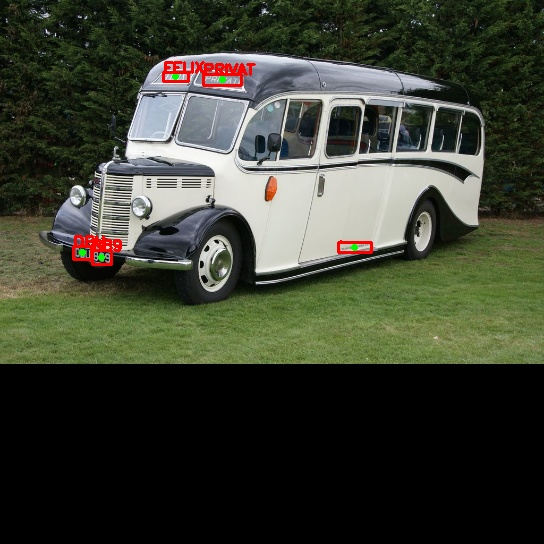

In [40]:
Image('img_with_annotations.jpg')

In [ ]:
N = 4
slice_size = new_size // N
max_point_in_slice = 0
maxes = []
for img_idx in range(len(files)):
    slices = np.zeros((N, N), dtype=np.uint8)
    try:
        img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
    except KeyError:
        continue
    img = cv2.imread(files[img_idx])
    img, ratio = pre_process_image(img)
    for i in range(len(img_anns)):
        ann = bounding_boxes['anns'][img_anns[i]]
        points = ann['bbox']
        x1, y1, x2, y2 = int(points[0]), int(points[1]), int(points[2]) + int(points[0]), int(points[3]) + int(points[1])
        x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
        middle_point = get_middle_point([x1, y1, x2, y2])
        x, y = int(middle_point[0] / slice_size), int(middle_point[1] / slice_size)
        if ann['utf8_string'] != '.':
            slices[x, y] += 1
    max_point_in_slice = max(max_point_in_slice, np.max(slices))
    maxes.append(np.max(slices))
    print(f'{img_idx}/{len(files)} max_point_in_slice: {max_point_in_slice} maxes avg: {np.mean(maxes)}', end='\r')
    # break

print(max_point_in_slice)

In [10]:
N = 4
slice_size = new_size // N
max_point_in_slice = 5
y = []
x = []
for img_idx in range(len(files)):
    slices = np.zeros((N*N, max_point_in_slice, 5))
    slices_counts = np.zeros((N*N, 1), dtype=np.int32)
    try:
        img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
    except KeyError:
        continue
    img = cv2.imread(files[img_idx])
    img, ratio = pre_process_image(img)
    x.append(img)
    bb_count = 0
    for i in range(len(img_anns)):
        ann = bounding_boxes['anns'][img_anns[i]]
        points = ann['bbox']
        x1, y1, x2, y2 = points[0], points[1], points[2] + points[0], points[3] + points[1]
        x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
        middle_point = get_middle_point([x1, y1, x2, y2])
        x_slice, y_slice = int(middle_point[0] / slice_size), int(middle_point[1] / slice_size)
        if ann['utf8_string'] != '.':
            if slices_counts[y_slice * N + x_slice] >= max_point_in_slice:
                continue
            mid_x, mid_y = middle_point[0] - x_slice * slice_size, middle_point[1] - y_slice * slice_size
            mid_x, mid_y = mid_x / slice_size, mid_y / slice_size
            w, h = (x2 - x1) / slice_size, (y2 - y1) / slice_size
            slices[y_slice * N + x_slice][slices_counts[y_slice * N + x_slice]] = np.array([1, mid_x, mid_y, w, h])
            slices_counts[y_slice * N + x_slice] += 1
    y.append(slices)
    print(f'{img_idx}/{len(files)}', end='\r')
    # break

y = torch.tensor(y)
print(y.shape)
x = torch.tensor(x)
print(x.shape)

KeyboardInterrupt: 

In [41]:
idx_to_remove = []
for img_idx in range(len(files)):
    try:
        img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
    except KeyError:
        idx_to_remove.append(img_idx)
        continue

print('Number of images before removing images with no annotations: {}'.format(len(files)))
files = [i for j, i in enumerate(files) if j not in idx_to_remove]
img_ids = [i for j, i in enumerate(img_ids) if j not in idx_to_remove]
print('Number of images after removing images with no annotations: {}'.format(len(files)))

Number of images before removing images with no annotations: 25119
Number of images after removing images with no annotations: 21778


In [42]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomImageDataset(Dataset):
    def __init__(self, N, slice_size, max_point_in_slice, files, new_size, img_ids):
        self.img_paths = files
        self.N = N
        self.slice_size = new_size // N
        self.max_point_in_slice = max_point_in_slice
        self.img_ids = img_ids


    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = cv2.imread(img_path)
        image, ratio = pre_process_image(image)
        slices = np.zeros((self.N*self.N, self.max_point_in_slice, 5))
        slices_counts = np.zeros((self.N*self.N, 1), dtype=np.int32)
        img_anns = bounding_boxes['imgToAnns'][self.img_ids[idx][:-4]]
        for i in range(len(img_anns)):
            ann = bounding_boxes['anns'][img_anns[i]]
            points = ann['bbox']
            x1, y1, x2, y2 = points[0], points[1], points[2] + points[0], points[3] + points[1]
            x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
            middle_point = get_middle_point([x1, y1, x2, y2])
            x_slice, y_slice = int(middle_point[0] / self.slice_size), int(middle_point[1] / self.slice_size)
            if ann['utf8_string'] != '.':
                if slices_counts[y_slice * self.N + x_slice] >= self.max_point_in_slice:
                    continue
                mid_x, mid_y = middle_point[0] - x_slice * self.slice_size, middle_point[1] - y_slice * self.slice_size
                mid_x, mid_y = mid_x / self.slice_size, mid_y / self.slice_size
                w, h = (x2 - x1) / self.slice_size, (y2 - y1) / self.slice_size
                slices[y_slice * self.N + x_slice][slices_counts[y_slice * self.N + x_slice]] = np.array([1, mid_x, mid_y, w, h])
                slices_counts[y_slice * self.N + x_slice] += 1
        label = slices
        return image, label

files = np.array(files)
img_ids = np.array(img_ids)
rand_idxs = torch.randint(len(files), (5000,))
remaining_idxs = np.array([i for i in range(len(files)) if i not in rand_idxs])
val_files = files[rand_idxs]
val_img_ids = img_ids[rand_idxs]
train_files = files[remaining_idxs]
train_img_ids = img_ids[remaining_idxs]
N = 4
new_size = 544
slice_size = new_size // N
max_point_in_slice = 9
train_dataset = CustomImageDataset(N, slice_size, max_point_in_slice, train_files, new_size, train_img_ids)
val_dataset = CustomImageDataset(N, slice_size, max_point_in_slice, val_files, new_size, val_img_ids)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 544, 544, 3])
Labels batch shape: torch.Size([64, 16, 9, 5])


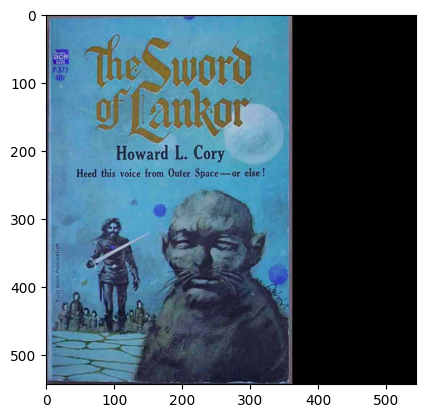

Label: tensor([[[1.0000, 0.1600, 0.4638, 0.1643, 0.0660],
         [1.0000, 0.1587, 0.5171, 0.1060, 0.0546],
         [1.0000, 0.1628, 0.4632, 0.1879, 0.1866],
         [1.0000, 0.1593, 0.6063, 0.1770, 0.0920],
         [1.0000, 0.1555, 0.6888, 0.1161, 0.0780],
         [1.0000, 0.7245, 0.5157, 0.6444, 0.6194],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[1.0000, 0.6103, 0.5513, 1.2503, 0.6290],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.

In [43]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")